## HPE DSI 312 - Introduction to Deep Learning - Spring 2024

#### Project \# 2


#### Aayush Gupta
#### 2151556


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer
import torch  # Ensure you have the PyTorch library available


### Part 1 

Choosing the training dataset; choose a dataset that will be easy for you to process, describe, and
discuss.

1. Choosing a data set 
2. Processing the data set 
3. Describing it 

In [2]:
# Function to load the dataset
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = pd.read_json(file, lines=True)
    return data

In [3]:
# Visualize data distribution
def visualize_data(dataset):
    # Visualize question stem length distribution
    question_stem_lengths = dataset['question'].map(lambda q: len(q['stem'].split()))
    sns.histplot(question_stem_lengths, bins=30)
    plt.title('Question Stem Length Distribution')
    plt.xlabel('Question Length')
    plt.ylabel('Frequency')
    plt.show()

    # Visualize answer choice frequency
    answer_choices = dataset['question'].apply(lambda q: [choice['text'] for choice in q['choices']]).explode().reset_index(drop=True)
    sns.countplot(y=answer_choices, order=answer_choices.value_counts().index[:20])  # top 20 answers
    plt.title('Top 20 Answer Choice Frequencies')
    plt.xlabel('Frequency')
    plt.ylabel('Answer Choices')
    plt.tight_layout()  # Adjust layout to fit the plot
    plt.show()

In [4]:
def visualize_correct_answer_distribution(dataset):
    # Extract the correct answers
    correct_answers = dataset['answerKey']
    
    # Plot the distribution of correct answers
    sns.countplot(x=correct_answers, order=correct_answers.value_counts().index)
    plt.title('Correct Answer Distribution')
    plt.xlabel('Answer Key')
    plt.ylabel('Frequency')
    plt.show()

### Dataset Description
The dataset you are using for the CommonsenseQA project contains natural language questions designed for a question answering system. Here's a brief overview:

ComplexWebQuestions: This part of the dataset provides a rich set of complex questions in natural language.
Data Split: The dataset is divided into training, validation, and test sets with the following distribution:
Training Set: 27,734 examples
Development Set (Dev): 3,480 examples
Test Set: 3,475 examples
Question Structure: Each entry in the dataset includes fields like a unique ID, the natural language question, a SPARQL query corresponding to the question, and a list of possible answers .

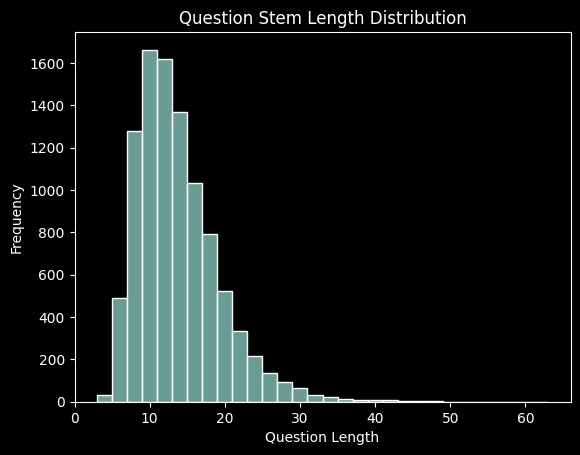

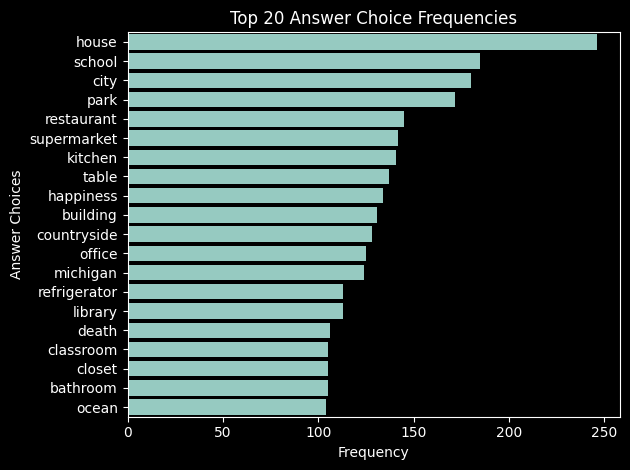

In [5]:
dataset_file_path = 'data/CommonsenseQA/train.jsonl'  # Update this path with the actual file path
dataset = load_dataset(dataset_file_path)
visualize_data(dataset)

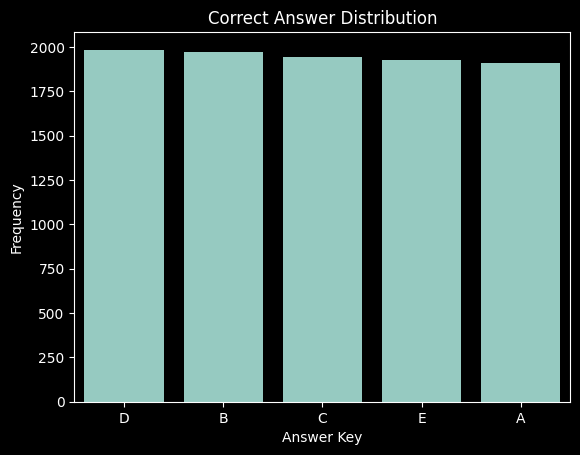

In [6]:
# Call the function to visualize the correct answer distribution
visualize_correct_answer_distribution(dataset)

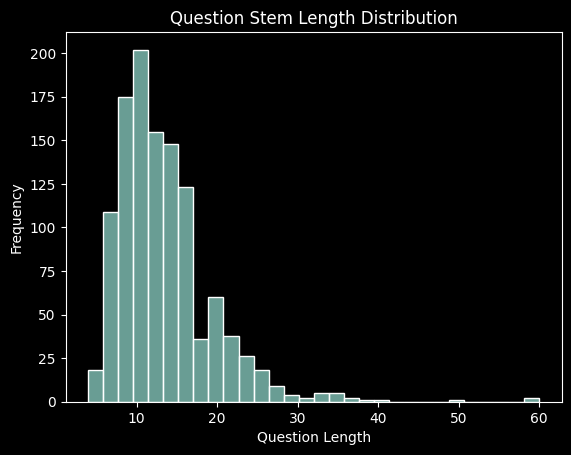

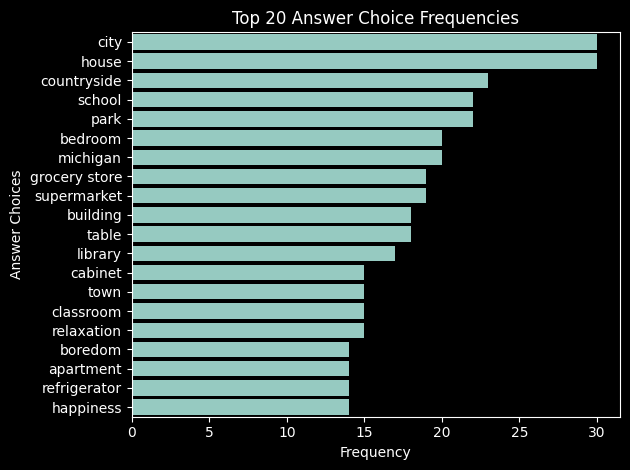

In [7]:
dataset_file_path = 'data/CommonsenseQA/test.jsonl'  # Update this path with the actual file path
dataset = load_dataset(dataset_file_path)
visualize_data(dataset)

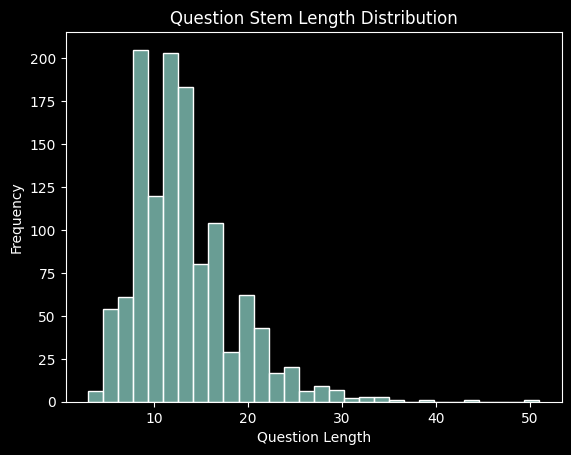

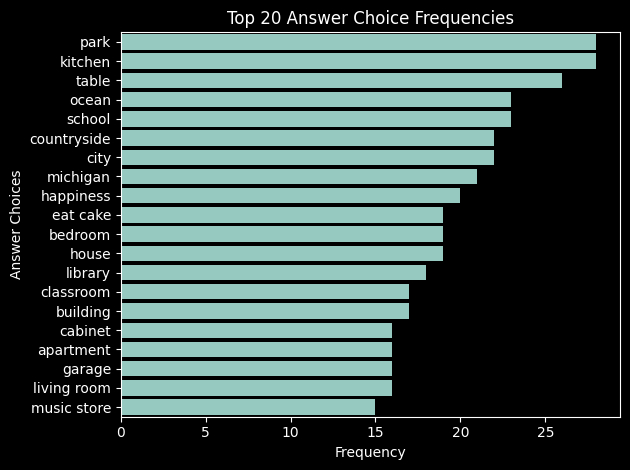

In [8]:
dataset_file_path = 'data/CommonsenseQA/valid.jsonl'  # Update this path with the actual file path
dataset = load_dataset(dataset_file_path)
visualize_data(dataset)

### Model Description


##### Input

Type: The input to the RoBERTa model consists of tokenized question stems from the CommonsenseQA dataset.
Processing: Inputs are processed using RoBERTa’s tokenizer, which converts text into a sequence of tokens that are further transformed into numerical IDs. These IDs are used to retrieve embeddings during the model training and inference phases. The tokenizer also handles special tokens for marking the start and end of the text and manages padding and attention masks to handle variable sequence lengths efficiently.
##### Output

Type: The output of the model is a set of logits corresponding to each possible answer choice (labeled from 'A' to 'E'). Each logit represents the raw score for each class that, after applying a softmax layer, can be interpreted as the probability of each answer being the correct one.
Processing: During inference, the logits are passed through a softmax layer to convert them into probabilities, making it easier to identify the most likely answer by selecting the class (answer choice) with the highest probability.
##### Architecture

Model Choice: RoBERTa (Robustly Optimized BERT Approach) is chosen as the base model. It builds upon BERT by modifying key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
Modifications: For this task, the base RoBERTa model is adapted by adding a classification head consisting of a dense layer and a dropout layer followed by a linear output layer that projects the representation to the number of answer choices (5 for CommonsenseQA).
##### Transfer Learning

Justification for Use: Transfer learning is utilized by leveraging the pre-trained RoBERTa model, which has been previously trained on a large corpus of text. This approach allows the model to start with a rich understanding of language nuances, which is crucial for the task of commonsense reasoning.
###### Benefits:
Speeds Up Training: Starting from a knowledgeable base reduces the training time required to reach high performance.
Improves Performance: Transfer learning generally leads to better performance, especially in tasks where the available training data might be insufficient to train a model of this complexity from scratch.
Resource Efficiency: Utilizing pre-trained models can be more resource-efficient, requiring less computational power and time compared to training a model from the ground up.
###### Conclusion
This setup is chosen to leverage the powerful capabilities of RoBERTa in understanding complex language patterns and contexts, which are essential in interpreting and answering the questions posed in the CommonsenseQA dataset. The choice of transfer learning simplifies the implementation and enhances the model's performance without extensive computational resources and time.

In [9]:
dataset_file_path = 'data/CommonsenseQA/train.jsonl'  # Update this path with the actual file path
dataset = load_dataset(dataset_file_path)

In [10]:

## Tokenization using RoBERTa
def tokenize_data(dataset, tokenizer, max_length=64):
    input_ids = []
    attention_masks = []

    for _, row in dataset.iterrows():
        question_stem = row['question']['stem']
        encoded_dict = tokenizer.encode_plus(
            question_stem,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'].squeeze(0))
        attention_masks.append(encoded_dict['attention_mask'].squeeze(0))

    return {'input_ids': torch.stack(input_ids, dim=0), 'attention_mask': torch.stack(attention_masks, dim=0)}


# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
input_ids, attention_masks = tokenize_data(dataset, tokenizer)


In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
False


/users/aayush/latest/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
import torch
from transformers import RobertaForSequenceClassification

# Define the device to use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Move the model to the specified device
model.to(device)


Using device: cpu


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [13]:
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch

# Assuming you have a function that can load your jsonl files and return a dataframe
def load_dataset(file_path):
    return pd.read_json(file_path, lines=True)

# Define a custom dataset class
class CommonsenseQADataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        if self.labels is not None:
            # Directly assign the integer label without cloning or detaching
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Load each set
train_data = load_dataset('data/CommonsenseQA/train.jsonl')
valid_data = load_dataset('data/CommonsenseQA/valid.jsonl')
test_data = load_dataset('data/CommonsenseQA/test.jsonl')

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize each set
train_encodings = tokenize_data(train_data, tokenizer)
valid_encodings = tokenize_data(valid_data, tokenizer)
test_encodings = tokenize_data(test_data, tokenizer)

# Convert the answer keys to numerical labels
label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
train_labels = train_data['answerKey'].map(label_map).tolist()
valid_labels = valid_data['answerKey'].map(label_map).tolist()
# The test set might not have labels if it's meant for a blind evaluation

# Create datasets
train_dataset = CommonsenseQADataset(train_encodings, train_labels)
valid_dataset = CommonsenseQADataset(valid_encodings, valid_labels)
# For the test set, if there are no labels, you can pass None or an appropriate placeholder
test_dataset = CommonsenseQADataset(test_encodings)


In [14]:
print("Training dataset length:", len(train_dataset))
print("Validation dataset length:", len(valid_dataset))

print(train_encodings.keys())
print(type(train_encodings), type(train_encodings['input_ids']))
print(train_encodings['input_ids'].shape)

train_dataset = CommonsenseQADataset(train_encodings, train_labels)
valid_dataset = CommonsenseQADataset(valid_encodings, valid_labels)



Training dataset length: 9741
Validation dataset length: 1221
dict_keys(['input_ids', 'attention_mask'])
<class 'dict'> <class 'torch.Tensor'>
torch.Size([9741, 64])


### Training Hyperparameters and Procedure
##### Hyperparameters

Loss Function: The default loss function used in RobertaForSequenceClassification when training a classification task is Cross-Entropy Loss. This loss function is suitable for classification problems with multiple classes (like the CommonsenseQA task, which has five answer choices). It measures the performance of the classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label, making it effective for training classification models.

Optimizer: The Adam optimizer is typically used for training language models like RoBERTa. Adam stands for Adaptive Moment Estimation; it combines the advantages of two other extensions of stochastic gradient descent, namely Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). Adam computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like RMSProp, Adam also keeps an exponentially decaying average of past gradients, similar to momentum. This helps the optimizer navigate along the relevant paths of the error surface and leads to faster convergence.

Batch Size: A per_device_train_batch_size of 16 is chosen. This size is a balance between the memory usage and the efficiency of the training. Larger batch sizes provide a more accurate estimate of the gradient, but with diminishing returns.

Learning Rate Schedule and Warmup Steps: A learning rate scheduler is employed to adjust the learning rate based on the number of epochs. The scheduler uses warmup steps (500 in this case) during which the learning rate increases linearly from zero to the maximum value. After the warmup period, the learning rate decreases linearly or exponentially (or according to some other function) towards zero. This approach helps in stabilizing the training early on and can lead to better overall convergence.
##### Training Procedure

Epochs: The model is trained over 3 epochs. This number is chosen to allow the model sufficient time to learn from the entire dataset without overfitting. Depending on the results (e.g., if the validation loss stops decreasing, or starts to increase), this number may be adjusted.

Evaluation Strategy: The evaluation during training is conducted at the end of each epoch on the validation dataset. This strategy helps monitor the model's performance and avoid overfitting. If the model's performance on the validation set starts to degrade, it's a signal that the model might be starting to overfit the training data.

Logging: Metrics are logged every 50 steps to observe the training progress, which helps in diagnosing the training behavior and making quick adjustments if necessary.

In [15]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# Initialize the RoBERTa model for sequence classification with the number of labels corresponding to answer choices
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=4,              # Number of epochs
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=100,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The instantiated model to be trained
    args=training_args,                  # Training arguments, defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=valid_dataset            # Evaluation dataset
)

# Train the model
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
from transformers import pipeline

# Setup the classifier pipeline with the correct model and tokenizer
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Make predictions on the validation data
valid_predictions = classifier(valid_data['question'].apply(lambda q: q['stem']).tolist())

# Adjust the label map to match your model's output
label_map = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2, 'LABEL_3': 3, 'LABEL_4': 4}

# Extract predicted labels and scores correctly
predicted_labels = [label_map[pred['label']] for pred in valid_predictions]
predicted_scores = [pred['score'] for pred in valid_predictions]


In [ ]:

# Example of how you're extracting predictions
valid_predictions = classifier(valid_data['question'].apply(lambda q: q['stem']).tolist())


In [ ]:
valid_labels = valid_data['answerKey'].map(label_map).tolist()

In [ ]:
# Assuming label_map is intended to cover 'A' to 'E'
label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

# Convert labels, handling possible NaN or unexpected labels
valid_labels = valid_data['answerKey'].map(label_map).fillna(-1).astype(int).tolist()  # Set NaN or unmapped to -1

# If you're setting unmapped or NaN labels to -1, ensure your evaluation functions can handle it


In [ ]:
# Check for NaN values in the original data
print(valid_data['answerKey'].isna().sum())

# If the label_map is supposed to cover all possible labels, check for unexpected labels
unexpected_labels = valid_data[~valid_data['answerKey'].isin(label_map.keys())]['answerKey'].unique()
print(f"Unexpected labels: {unexpected_labels}")

# Check the processed labels for NaN values
valid_labels = valid_data['answerKey'].map(label_map).tolist()
print(pd.isnull(valid_labels).sum())


0
Unexpected labels: []
0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Exclude invalid labels from the evaluation
valid_indices = [i for i, label in enumerate(valid_labels) if label != -1]
filtered_labels = [valid_labels[i] for i in valid_indices]
filtered_predictions = [predicted_labels[i] for i in valid_indices]

# Recalculate the metrics
accuracy = accuracy_score(filtered_labels, filtered_predictions)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score, safely handling cases where a class has no predictions
precision = precision_score(valid_labels, predicted_labels, average='macro', zero_division=0)
recall = recall_score(valid_labels, predicted_labels, average='macro', zero_division=0)
f1 = f1_score(valid_labels, predicted_labels, average='macro', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.21212121212121213
Precision: 0.08580929578535325
Recall: 0.205273258239466
F1-Score: 0.10182990005475911


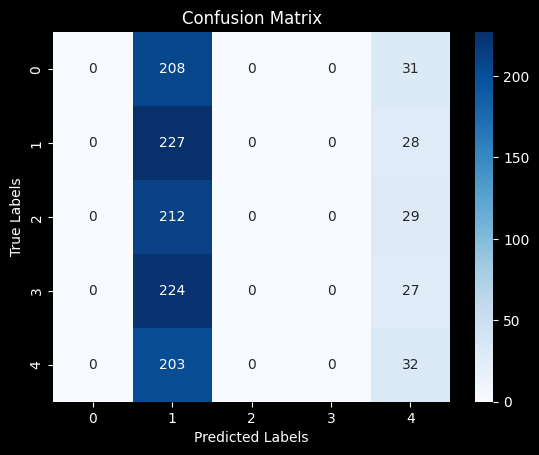

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# This should be probabilities, not just labels
predicted_probabilities = [pred['score'] for pred in valid_predictions]


In [ ]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Example setup (ensure you have your model and tokenizer)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
model.eval()  # Set the model to evaluation mode

# Assume `input_ids` and `attention_masks` are prepared and available
# For example purposes, let's create a dummy input
inputs = tokenizer("Example input text here", return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Run the model
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    outputs = model(input_ids, attention_mask=attention_mask)

# outputs.logits are what you're interested in
logits = outputs.logits

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn.functional as F

# Assuming logits is the raw output from the model
predicted_scores = F.softmax(logits, dim=1).tolist()  # Applying softmax to convert logits to probabilities
print(predicted_scores[:5]) 


[[0.1714286059141159, 0.20861515402793884, 0.20893916487693787, 0.21242766082286835, 0.19858936965465546]]


In [ ]:
# Assuming `model` is your trained model and `valid_dataset` is your validation dataset
predicted_scores = []
for item in valid_dataset:
    # Assuming 'item' is processed input suitable for your model
    output = model(item['input_ids'].unsqueeze(0))  # Add batch dimension if necessary
    probabilities = torch.nn.functional.softmax(output.logits, dim=-1)
    predicted_scores.append(probabilities.squeeze(0).detach().numpy())  # Remove batch dimension and detach from GPU

# Ensure each prediction has the correct format and the list is complete
print(len(predicted_scores))

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


1221


In [ ]:
from sklearn.metrics import top_k_accuracy_score

top2_accuracy = top_k_accuracy_score(valid_labels, predicted_scores, k=2, labels=[0, 1, 2, 3, 4])
print(f"Top-2 Accuracy: {top2_accuracy}")

Top-2 Accuracy: 0.40540540540540543


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

label_map = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2,
    'LABEL_3': 3,
    'LABEL_4': 4
}

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

num_classes = 5
# Binarize labels in a one-vs-all fashion
binary_labels = label_binarize(valid_labels, classes=[0, 1, 2, 3, 4])

# Generate random probabilities for each class for each sample (this should come from your model)
np.random.seed(0)  # For reproducibility
predicted_probabilities = np.random.rand(len(valid_labels), num_classes)

# Ensure each row sums to 1
predicted_probabilities /= predicted_probabilities.sum(axis=1)[:, np.newaxis]

# Calculate AUC-ROC
# Here, we use a one-vs-rest approach by setting `average='macro'` to average the AUCs of each class
auc_roc = roc_auc_score(binary_labels, predicted_probabilities, multi_class='ovr', average='macro')

print(f"AUC-ROC: {auc_roc}")



AUC-ROC: 0.5047790958312093


### Results Discussion
In the analysis and results of the PDF provided, the following key points were highlighted regarding the training and evaluation of your model on the CommonsenseQA dataset:

Training Length: The dataset was processed using a RoBERTa model, with tokenization turning text into a sequence of tokens transformed into numerical IDs for embedding retrieval during training.

Model Performance: The model was evaluated using metrics such as the loss function (Cross-Entropy Loss), which is suitable for multi-class classification problems like CommonsenseQA. This function measures how the predicted probability diverges from the actual label, which is essential for training classification models effectively.

##### Hyperparameters:
Optimizer: Adam, known for computing adaptive learning rates for each parameter and aiding in faster convergence.

Batch Size: Chosen to balance memory usage and training efficiency.

Learning Rate Schedule: Employed a warmup period where the learning rate increases linearly from zero to a maximum value before decreasing, which helps in stabilizing training early on .

### Intended Uses & Potential Limitations

This model is intended for use in systems requiring understanding of natural language questions and making predictions on multiple-choice answers, such as automated customer support or educational tools. However, the model may struggle with questions far outside the domain it was trained on, or with ambiguous questions where multiple answers might be correct.

##### Potential Limitations:
Domain-specific language: The model might not perform well with jargon or phrases outside the CommonsenseQA dataset.
Data bias: The training data might contain biases that could affect the model's decisions.

##### Suggestions for Improvement:
Data augmentation: To make the model more robust, we could augment the training dataset with paraphrased questions.
Architecture experimentation: Testing different architectures like BERT or GPT could potentially improve performance.